In [1]:
import numpy as np
import keras
from keras.layers import LSTM,Dense,Input,Flatten,TimeDistributed
from keras.models import Model
import os
import random

Using TensorFlow backend.
/home/abhi17/Work/Projects/Projects/Sutra/data/FakeNewsNet/code/dev37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/abhi17/Work/Projects/Projects/Sutra/data/FakeNewsNet/code/dev37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/abhi17/Work/Projects/Projects/Sutra/data/FakeNewsNet/code/dev37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be underst

## Data Generator

In [2]:
DATA_DIR = '../Generated_Data/Dynamics'
data = list(os.listdir(DATA_DIR))
random.shuffle(data)


train_data = data[0:int((0.7)*len(data))]
test_data  = data[int(-0.3*len(data)):]

print("Train size : ",len(train_data))
print("Test size : ",len(test_data))

Train size :  552
Test size :  236


In [3]:
class DataGenerator(keras.utils.Sequence):
    
    def __init__(self,base_path,datalist,batch_size=32,shuffle=True):
        self.base_path = base_path
        self.datalist = datalist
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.on_epoch_end()
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.datalist) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.datalist[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.datalist))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = []
        Y = []
        for article in list_IDs_temp:
            X_path = self.base_path+"/"+article+"/"+"X.npy"
            Y_path = self.base_path+"/"+article+"/"+"Y.npy"
            
            x = np.load(X_path)
            y = np.load(Y_path)
            X.append(x)
            Y.append(y)

        X = np.array(X)
        Y = np.array(Y)

        return X, Y        

In [4]:
train_generator = DataGenerator(base_path=DATA_DIR,datalist=train_data)
test_generator  = DataGenerator(base_path=DATA_DIR,datalist=test_data)

## Model Definition

In [5]:
def fakeNewsModel(input_shape=(50,50)):
    
    inp  = Input(shape=input_shape)
    
    lstm1 = LSTM(100,dropout=0.3,return_sequences=True,activation="tanh")(inp)
    d1    = TimeDistributed(Dense(100,activation="relu"))(lstm1)
    lstm2 = LSTM(50,activation="tanh",return_sequences=True)(d1)
    d2    = TimeDistributed(Dense(100,activation="relu"))(lstm2)
    
    
    flat = Flatten()(d2)
    
    out  = Dense(2,activation="softmax")(flat)
    
    model = Model(inputs=inp,outputs=out)
    model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["acc"])
    
    return model

In [6]:
model = fakeNewsModel()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 100)           60400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 100)           10100     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 50)            30200     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 50, 100)           5100      
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_____________________________________________________

In [7]:
history = model.fit(train_generator,epochs=150,validation_data=test_generator)

Instructions for updating:
Use tf.cast instead.
Epoch 1/150
17/17 [==============================] - 2s 105ms/step - loss: 0.6941 - acc: 0.5680 - val_loss: 0.6739 - val_acc: 0.6027
Epoch 2/150
17/17 [==============================] - 1s 71ms/step - loss: 0.6640 - acc: 0.6140 - val_loss: 0.7044 - val_acc: 0.6116
Epoch 3/150
17/17 [==============================] - 1s 76ms/step - loss: 0.6694 - acc: 0.6121 - val_loss: 0.5468 - val_acc: 0.6652
Epoch 4/150
17/17 [==============================] - 1s 74ms/step - loss: 0.6755 - acc: 0.5827 - val_loss: 0.7513 - val_acc: 0.6473
Epoch 5/150
17/17 [==============================] - 1s 77ms/step - loss: 0.6595 - acc: 0.6305 - val_loss: 0.6469 - val_acc: 0.6964
Epoch 6/150
17/17 [==============================] - 1s 80ms/step - loss: 0.6452 - acc: 0.6342 - val_loss: 0.5802 - val_acc: 0.7143
Epoch 7/150
17/17 [==============================] - 1s 78ms/step - loss: 0.6429 - acc: 0.6415 - val_loss: 0.5841 - val_acc: 0.6964
Epoch 8/150
17/17 [========

17/17 [==============================] - 1s 76ms/step - loss: 0.3469 - acc: 0.8548 - val_loss: 1.3080 - val_acc: 0.6384
Epoch 61/150
17/17 [==============================] - 1s 75ms/step - loss: 0.3259 - acc: 0.8640 - val_loss: 0.9221 - val_acc: 0.6830
Epoch 62/150
17/17 [==============================] - 1s 75ms/step - loss: 0.3204 - acc: 0.8603 - val_loss: 1.0987 - val_acc: 0.6696
Epoch 63/150
17/17 [==============================] - 1s 77ms/step - loss: 0.3220 - acc: 0.8640 - val_loss: 1.4779 - val_acc: 0.6830
Epoch 64/150
17/17 [==============================] - 1s 81ms/step - loss: 0.3317 - acc: 0.8585 - val_loss: 1.1558 - val_acc: 0.6741
Epoch 65/150
17/17 [==============================] - 1s 78ms/step - loss: 0.3027 - acc: 0.8621 - val_loss: 1.1485 - val_acc: 0.7009
Epoch 66/150
17/17 [==============================] - 1s 79ms/step - loss: 0.3109 - acc: 0.8676 - val_loss: 0.7724 - val_acc: 0.6473
Epoch 67/150
17/17 [==============================] - 1s 78ms/step - loss: 0.3036 

17/17 [==============================] - 1s 75ms/step - loss: 0.1864 - acc: 0.9246 - val_loss: 1.6921 - val_acc: 0.6964
Epoch 122/150
17/17 [==============================] - 1s 74ms/step - loss: 0.1889 - acc: 0.9228 - val_loss: 1.4631 - val_acc: 0.6875
Epoch 123/150
17/17 [==============================] - 1s 74ms/step - loss: 0.1872 - acc: 0.9246 - val_loss: 1.4999 - val_acc: 0.6920
Epoch 124/150
17/17 [==============================] - 1s 74ms/step - loss: 0.1845 - acc: 0.9228 - val_loss: 1.7519 - val_acc: 0.6920
Epoch 125/150
17/17 [==============================] - 1s 74ms/step - loss: 0.1858 - acc: 0.9265 - val_loss: 2.0164 - val_acc: 0.6741
Epoch 126/150
17/17 [==============================] - 1s 74ms/step - loss: 0.1825 - acc: 0.9228 - val_loss: 0.8878 - val_acc: 0.6830
Epoch 127/150
17/17 [==============================] - 1s 75ms/step - loss: 0.1862 - acc: 0.9210 - val_loss: 0.9036 - val_acc: 0.6786
Epoch 128/150
17/17 [==============================] - 1s 75ms/step - loss: 

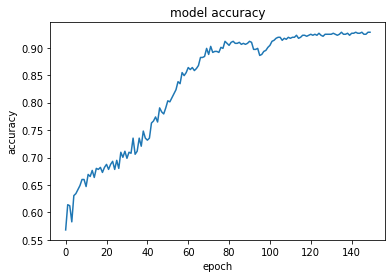

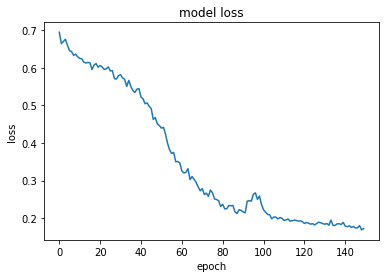

In [9]:

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [10]:
model.save("../Model/model_v3.h5")